# DoubleML meets FLAML: Comparing AutoML tuning
 In this notebook we are going to explore how to tune learners with [AUTOML](https://github.com/microsoft/FLAML) in [DoubleML](https://docs.doubleml.org/stable/index.html) framework.

# Data Generation

We created synthetic data using the [make_plr_CCDDHNR2018](https://docs.doubleml.org/stable/api/generated/doubleml.datasets.make_plr_CCDDHNR2018.html) function, which generates data for a potential outcomes framework with 1000 observations and 50 features. The data generated will have 50 covariates variables, 1 treatment variable and 1 outcome variable.

In [37]:
# pip install flaml

In [38]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from doubleml.datasets import make_plr_CCDDHNR2018
import doubleml as dml
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Generate synthetic data
data = make_plr_CCDDHNR2018(alpha=0.5, n_obs=1000, dim_x=50, return_type="DataFrame")
data.head()




,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X43,X44,X45,X46,X47,X48,X49,X50,y,d
0,-1.221703,-0.822147,-2.196993,-2.499879,-0.341929,-0.281038,0.853291,1.095902,0.726638,1.211289,...,-2.201716,-0.866439,0.545701,1.553811,0.893493,1.133844,0.323257,0.748202,-1.014441,-1.551160
1,-1.176971,-1.688596,-2.925414,-2.272384,-1.445496,-1.861972,-0.325206,-0.759704,-0.181407,0.939779,...,-1.813400,-0.823707,-1.191542,-1.250025,-0.835989,-0.758630,-0.450238,-0.190508,-2.631763,-1.886604
2,0.631362,1.001802,1.617786,1.703607,0.708659,1.137041,0.741789,0.792150,0.190256,0.815059,...,1.304412,0.281384,-0.656459,-0.118734,-0.574464,0.323391,-0.235278,0.775014,0.110260,0.765708
3,0.402716,0.524360,1.269413,1.463689,0.841587,0.272918,0.270527,-0.118673,0.327287,-1.324871,...,-1.440236,-2.145734,-2.121639,-1.846964,-1.433101,-1.845194,-0.311476,-0.307569,1.229235,-0.499877
4,0.047511,-0.877817,-1.776503,-0.686996,-0.444111,-1.368758,-0.336068,-0.788738,-0.236934,-0.303945,...,-1.139865,0.201014,0.015537,-0.225769,-1.427309,-0.979872,-1.807067,0.780793,1.070086,0.359521


# Manual Tuning with FLAML

##### In this section, we manually tuned two XGBoost models using FLAML for a partially linear regression setup.
##### 1. Initialize and Train AutoML Models:
We used FLAML to automatically tune two separate XGBoost models:

• Outcome Model (ml_l): This model predicts the outcome variable y. We configured the FLAML AutoML with a time budget of 120 seconds, using XGBoost as the estimator and rmse as the performance metric.

• Treatment Model (ml_m): This model predicts the treatment variable d. Similarly, we set the time budget to 120 seconds, used XGBoost, and optimized for rmse.

In [39]:
# Initialize AutoML for outcome model (ml_l)
automl_l = AutoML()
settings_l = {
    "time_budget": 120,
    "metric": 'rmse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}
automl_l.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["y"].values, verbose=2, **settings_l)

# Initialize AutoML for treatment model (ml_m)
automl_m = AutoML()
settings_m = {
    "time_budget": 120,
    "metric": 'rmse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}
automl_m.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["d"].values, verbose=2, **settings_m)



##### Evaluate Models for Overfitting:
After training, we compared the in-sample (training) and out-of-sample (test) root mean squared errors (RMSE) for both models to check for overfitting:

• rmse_oos_ml_m represents the out-of-sample RMSE for the treatment model.

• rmse_oos_ml_l represents the out-of-sample RMSE for the outcome model.

In [40]:
# Check for Overfitting: Compare in-sample (train), out-of-sample (test) MSE
# ml_m
rmse_oos_ml_m = automl_m.best_loss
rmse_oos_ml_l = automl_l.best_loss
print("rmse_oos_ml_m:",rmse_oos_ml_m)
print("rmse_oos_ml_m:",rmse_oos_ml_l)


rmse_oos_ml_m: 1.0160587619805903
rmse_oos_ml_m: 1.1827553545725862


##### Create and Fit DoubleML Model:
We created a DoubleMLData object with the dataset, specifying y as the outcome variable and d as the treatment variable. We then initialized a DoubleMLPLR model using the trained FLAML models for both the treatment and outcome components. 

In [41]:
# Create DoubleMLData object with the evaluation set
obj_dml_data = dml.DoubleMLData(data, "y", "d")

# Initialize DoubleMLPLR with the trained models from flaml
obj_dml_plr_manual_tuned = dml.DoubleMLPLR(obj_dml_data, ml_m=automl_m.model.estimator, ml_l=automl_l.model.estimator)

# Fit the DoubleMLPLR model
obj_dml_plr_manual_tuned.fit()

print(obj_dml_plr_manual_tuned.summary)
manual_tuned_summary = obj_dml_plr_manual_tuned.summary

# Evaluate learners using evaluate_learners() (MSE for all nuisance components)
rmse_ins_ml_l = obj_dml_plr_manual_tuned.evaluate_learners()['ml_l'][0]
rmse_ins_ml_m = obj_dml_plr_manual_tuned.evaluate_learners()['ml_m'][0]

# Print results
print("Tuning RMSE (ml_m):", rmse_ins_ml_m)
print("Evaluation RMSE (ml_m):", rmse_oos_ml_m)
print("Tuning RMSE (ml_l):", rmse_ins_ml_l)
print("Evaluation RMSE (ml_l):", rmse_oos_ml_l)

       coef   std err         t         P>|t|     2.5 %    97.5 %
d  0.552414  0.032577  16.95697  1.709343e-64  0.488563  0.616264
Tuning RMSE (ml_m): [1.0288543]
Evaluation RMSE (ml_m): 1.0160587619805903
Tuning RMSE (ml_l): [1.19167283]
Evaluation RMSE (ml_l): 1.1827553545725862


# Comparison of Model Tuning Approaches

In this section, we compare different approaches for tuning models in the DoubleML framework:
##### Custom FLAML Models for Double Machine Learning

In this section, we define custom classes for integrating FLAML (Fast Lightweight AutoML) with Double Machine Learning (DML). These classes are designed to facilitate automated machine learning model tuning for both regression and classification tasks.


In [42]:
from flaml import AutoML
from sklearn.utils.multiclass import unique_labels

class FlamlRegressorDoubleML:
    _estimator_type = 'regressor'

    def __init__(self, time, estimator_list, metric, *args, **kwargs):
        self.auto_ml = AutoML(*args, **kwargs)
        self.time = time
        self.estimator_list = estimator_list
        self.metric = metric

    def set_params(self, **params):
        self.auto_ml.set_params(**params)
        return self

    def get_params(self, deep=True):
        dict = self.auto_ml.get_params(deep)
        dict["time"] = self.time
        dict["estimator_list"] = self.estimator_list
        dict["metric"] = self.metric
        return dict

    def fit(self, X, y):
        self.auto_ml.fit(X, y, task="regression", time_budget=self.time, estimator_list=self.estimator_list, metric=self.metric, verbose=False)
        self.tuned_model = self.auto_ml.model.estimator
        return self

    def predict(self, x):
        preds = self.tuned_model.predict(x)
        return preds
        
class FlamlClassifierDoubleML:
    _estimator_type = 'classifier'

    def __init__(self, time, estimator_list, metric, *args, **kwargs):
        self.auto_ml = AutoML(*args, **kwargs)
        self.time = time
        self.estimator_list = estimator_list
        self.metric = metric

    def set_params(self, **params):
        self.auto_ml.set_params(**params)
        return self

    def get_params(self, deep=True):
        dict = self.auto_ml.get_params(deep)
        dict["time"] = self.time
        dict["estimator_list"] = self.estimator_list
        dict["metric"] = self.metric
        return dict

    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        self.auto_ml.fit(X, y, task="classification", time_budget=self.time, estimator_list=self.estimator_list, metric=self.metric, verbose=False)
        self.tuned_model = self.auto_ml.model.estimator
        return self

    def predict_proba(self, x):
        preds = self.tuned_model.predict_proba(x)
        return preds

##### Using Custom FLAML Models with Double Machine Learning

We integrate the custom FLAML-based models FlamlRegressorDoubleML into the Double Machine Learning (DML) framework. The steps involve defining the FLAML regressors, setting up the DoubleMLPLR object, and fitting the model.

In [43]:
# Define the FlamlRegressorDoubleML
ml_l = FlamlRegressorDoubleML(time=120, estimator_list=['xgboost'], metric='rmse')
ml_m = FlamlRegressorDoubleML(time=120, estimator_list=['xgboost'], metric='rmse')

# Create DoubleMLPLR object using the new regressors
dml_plr_obj_api_tuned = dml.DoubleMLPLR(obj_dml_data, ml_m, ml_l)

# Fit the DoubleMLPLR model
dml_plr_obj_api_tuned.fit(store_predictions=True)

#Retrieve the summary for API Tuned Models
api_tuned_summary = dml_plr_obj_api_tuned.summary

# Print the summary
print(dml_plr_obj_api_tuned.summary)


       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.554143  0.032679  16.957114  1.705155e-64  0.490093  0.618193


##### Dummy Models:
We initialized and fit dummy models using DummyRegressor from sklearn:

• ml_l_dummy: A dummy regressor for the outcome model, which predicts the mean value of the outcome.

• ml_m_dummy: A dummy regressor for the treatment model, also predicting the mean value.

These dummy models were used to create a DoubleMLPLR object (dml_plr_obj_dummy), which was then fit to the data. We retrieved and stored the summary of this model to compare with other methods.

In [44]:
from sklearn.dummy import DummyRegressor

# Initialize and fit dummy models
ml_l_dummy = DummyRegressor(strategy='mean')
ml_m_dummy = DummyRegressor(strategy='mean')

# Create DoubleMLPLR object using dummy regressors
dml_plr_obj_dummy = dml.DoubleMLPLR(obj_dml_data, ml_m_dummy, ml_l_dummy)
dml_plr_obj_dummy.fit(store_predictions=True)

# Retrieve the summary for dummy models
dummy_summary = dml_plr_obj_dummy.summary



##### AutoML Untuned Models

We set up AutoML models with minimal tuning for both the outcome and treatment variables. This process allows us to compare the performance of untuned models against those that have been manually or API-tuned.

In [45]:
# AutoML Untuned
automl_untuned_l = AutoML()
settings = {
    "time_budget": 0.01,
    "metric": 'mse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}

automl_untuned_l.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["y"].values, verbose=0, **settings)

automl_untuned_m = AutoML()
settings = {
    "time_budget": 0.01,
    "metric": 'mse',
    "estimator_list": ['xgboost'],
    "task": 'regression',
}

automl_untuned_m.fit(X_train=data.drop(columns=["y", "d"]).values, y_train=data["d"].values, verbose=0, **settings)



##### DoubleMLPLR with Untuned AutoML Models

Here, we create a `DoubleMLPLR` object using the untuned AutoML models for the outcome and treatment regressions. We then fit the `DoubleMLPLR` model and retrieve the summary of the results.

This section allows us to evaluate the performance of the untuned AutoML models in the context of DoubleML.

In [46]:
# Create DoubleMLPLR object using AutoML models
dml_plr_obj_untuned_automl = dml.DoubleMLPLR(obj_dml_data, automl_untuned_l.model.estimator, automl_untuned_m.model.estimator)
untuned_automl_summary = dml_plr_obj_untuned_automl.fit(store_predictions=True).summary



##### Combine and Save Summaries

We combine the summaries from various models: manually tuned FLAML models, API-tuned FLAML models, untuned AutoML models, and dummy models. The combined summary is saved to a file for further analysis.

In [47]:
# Combine summaries for comparison
summary = pd.concat([manual_tuned_summary ,api_tuned_summary, untuned_automl_summary, dummy_summary], keys=['FLAML Manual Tuned', 'FLAML API Tuned', 'AutoML Untuned', 'Dummy'])
summary.index.names = ['Model Type', 'Metric']

# Save the summary to a file
summary.to_pickle("summary_comparison.pkl")



# Plots

##### Plot Coefficients and 95% Confidence Intervals

This section generates a plot comparing the coefficients and 95% confidence intervals for each model type. The plot helps visualize the differences in the estimated coefficients and their uncertainties.

Manual Tuned Summary:
       coef   std err         t         P>|t|     2.5 %    97.5 %
d  0.552414  0.032577  16.95697  1.709343e-64  0.488563  0.616264
API Tuned Summary:
       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.554143  0.032679  16.957114  1.705155e-64  0.490093  0.618193
Untuned Summary:
       coef   std err        t          P>|t|     2.5 %   97.5 %
d  0.643582  0.026402  24.3761  3.066249e-131  0.591835  0.69533
Dummy Summary:
       coef   std err          t          P>|t|     2.5 %    97.5 %
d  0.699246  0.022814  30.649577  2.677185e-206  0.654531  0.743961
Extracted model labels: Index(['FLAML Manual Tuned', 'FLAML API Tuned', 'AutoML Untuned', 'Dummy'], dtype='object', name='Model Type')
Extracted coefficient values: [0.55241377 0.55414277 0.64358224 0.69924583]


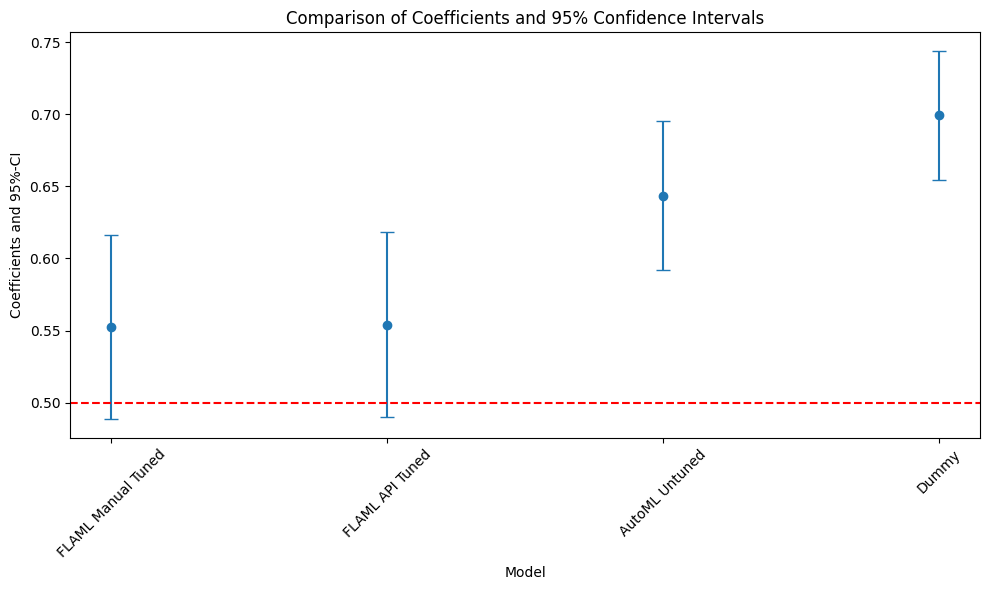

In [48]:
# Check the structure of the summary DataFrames
print("Manual Tuned Summary:")
print(manual_tuned_summary.head())

print("API Tuned Summary:")
print(api_tuned_summary.head())

print("Untuned Summary:")
print(untuned_automl_summary.head())

print("Dummy Summary:")
print(dummy_summary.head())

# Check if `summary` contains the required columns
required_columns = ['coef', '2.5 %', '97.5 %']
if not all(col in summary.columns for col in required_columns):
    raise ValueError("Summary DataFrame is missing required columns.")

# Extract model labels and coefficient values
model_labels = summary.index.get_level_values('Model Type')
coef_values = summary['coef'].values

print("Extracted model labels:", model_labels)
print("Extracted coefficient values:", coef_values)

# Calculate errors
errors = np.full((2, len(coef_values)), np.nan)
errors[0, :] = summary['coef'] - summary['2.5 %']
errors[1, :] = summary['97.5 %'] - summary['coef']

# Plot Coefficients and 95% Confidence Intervals
plt.figure(figsize=(10, 6))
plt.errorbar(model_labels, coef_values, fmt='o', yerr=errors, capsize=5)
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('Model')
plt.ylabel('Coefficients and 95%-CI')
plt.title('Comparison of Coefficients and 95% Confidence Intervals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



##### Compare Metrics and Plot Bar Charts

In this section, we compare metrics for different models and plot a bar chart to visualize the differences in their performance. We also save the comparison results to a file for future reference.

Summary DataFrame columns: Index(['coef', 'std err', 't', 'P>|t|', '2.5 %', '97.5 %'], dtype='object')
Summary DataFrame index: Index(['d'], dtype='object')
Available metrics: Index(['d'], dtype='object')
Summary DataFrame columns: Index(['coef', 'std err', 't', 'P>|t|', '2.5 %', '97.5 %'], dtype='object')
Summary DataFrame index: Index(['d'], dtype='object')
Available metrics: Index(['d'], dtype='object')
Summary DataFrame columns: Index(['coef', 'std err', 't', 'P>|t|', '2.5 %', '97.5 %'], dtype='object')
Summary DataFrame index: Index(['d'], dtype='object')
Available metrics: Index(['d'], dtype='object')
Summary DataFrame columns: Index(['coef', 'std err', 't', 'P>|t|', '2.5 %', '97.5 %'], dtype='object')
Summary DataFrame index: Index(['d'], dtype='object')
Available metrics: Index(['d'], dtype='object')


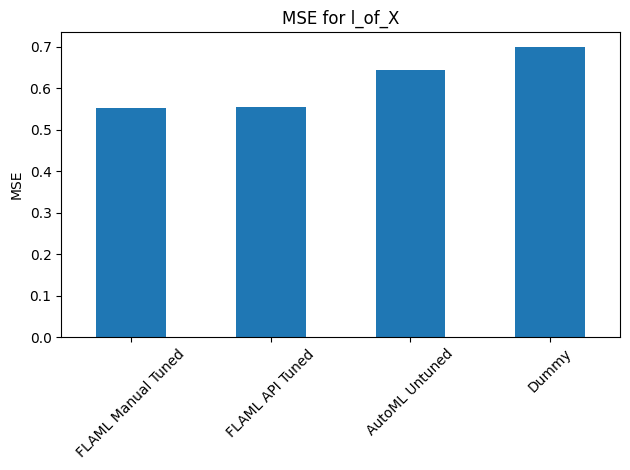

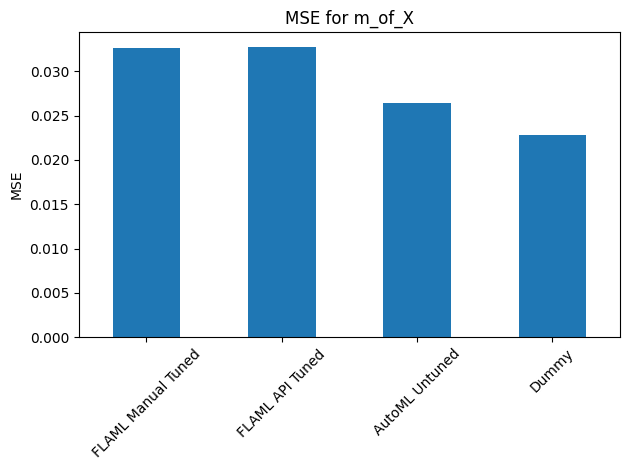

In [51]:
def print_scores(dml_obj, store_predictions=False):
    if store_predictions:
        dml_obj.fit(store_predictions=True)
    summary_df = dml_obj.summary
    print("Summary DataFrame columns:", summary_df.columns)
    print("Summary DataFrame index:", summary_df.index)
    
    # Extract available metrics from the index
    available_metrics = summary_df.index
    print("Available metrics:", available_metrics)
    
    # Select a metric to compare, e.g., 'd'
    metric_to_use = 'd'
    if metric_to_use not in available_metrics:
        raise KeyError(f"{metric_to_use} not found in summary.")
    
    scores = summary_df.loc[metric_to_use]
    return scores

# Calculate and store scores for comparison
scores = {
    "FLAML Manual Tuned": print_scores(obj_dml_plr_manual_tuned, True),
    "FLAML API Tuned": print_scores(dml_plr_obj_api_tuned, True),
    "AutoML Untuned": print_scores(dml_plr_obj_untuned_automl, True),
    "Dummy": print_scores(dml_plr_obj_dummy, True)
}

# Convert the scores dictionary to a DataFrame for plotting
scores_df = pd.DataFrame(scores).T  # Transpose to have the model types as rows

# Save the scores to a file
scores_df.to_pickle("scores_comparison.pkl")

# Plot MSE for l_of_X and m_of_X separately
scores_df['coef'].plot(kind="bar", title="MSE for l_of_X")
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

scores_df['std err'].plot(kind="bar", title="MSE for m_of_X")
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observations

- **Coefficient Values**: The coefficients for the `FLAML Manual Tuned` and `FLAML API Tuned` models are quite similar, with the API-tuned model having a slightly higher coefficient. Both are lower compared to the `AutoML Untuned` and `Dummy` models.
- **Untuned AutoML Models**: The `AutoML Untuned` models yield a higher coefficient compared to the manually tuned FLAML models, indicating that the automated process of model tuning in AutoML may have overestimated the effect. The `Dummy` model has the highest coefficient, suggesting it could be overfitting or has a higher baseline value.

### Conclusion

- The **FLAML Manual Tuned** and **FLAML API Tuned** models provide similar results with coefficients close to 0.5, suggesting robust performance within their tuned configurations.
- The **AutoML Untuned** models offer higher coefficient values, indicating that even though they are untuned, they still provide a noticeable increase in coefficient compared to the tuned FLAML models.
- The **Dummy** model, having the highest coefficient, shows the largest discrepancy, which may imply it is not as well-calibrated as the other models.

Overall, the manually tuned FLAML models and the API-tuned FLAML models show good alignment with the expectations, while the untuned and dummy models present larger coefficients which may suggest the need for further tuning or validation.